# Surface Mass Balance: XGB 

Import relevant Libaries 

In [1]:
%pip install pyarrow
%pip install plotly
%pip install feature_engine
%pip update pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "update"
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats

# Visualizations
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns

# Set WD
import os
from pyrsistent import v
os.getcwd()
#os.chdir('/Users/asgerlyngeholst-hansen/Desktop/GEUS-Master-Thesis/')
#os.chdir('C:\\Users\\nifu18ab\\Desktop\\GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/GEUS-Master-Thesis')
os.chdir('/Users/nilsfulde/Desktop/Master_Thesis')

#### Load KM_L 

In [170]:
df = pd.read_csv('data/promice/preprocessed/daily/KAN_L.csv')

##### Pre-processing

In [171]:
#Remove the first NAN value for DELTA
df = df[df['Surface height from combined measurements DELTA'].notna()]

In [172]:
# This bit retrieve the indexes for all melting season categories and remove column from df
for category in ['pre', 'beginning', 'middle', 'end']:
    exec(f"indices_{category} = df[df['Melting Season'] == '{category}'].index")

# This bit retrieve the indexes for Ablation periods
for category in [True]:
    exec(f"indices_ablation = df[df['Ablation'] == {category}].index")

In [173]:
filtered = df[df['Ablation'] == True]
pd.DataFrame(filtered.isna().sum(), columns = ["Sum of missing values"])

,Sum of missing values
Unnamed: 0,0
stid,0
Datetime,0
Air pressure (upper boom),0
Air temperature (upper boom),0
Relative humidity (upper boom) - corrected,0
Specific humidity (upper boom),0
Wind speed (upper boom),0
Wind from direction (upper boom),0
Downwelling shortwave radiation - corrected,0


In [174]:
# This bit to include only relevant features
exclude_list = [                                                    'index', # excluded because of unimportant information
                                                                     'stid', # excluded because of unimportant information
                                                               'Unnamed: 0', # Old Index
                                                                 'Ablation',
                                                           'Melting Season',
                                              'year', 'month','day', 'hour' # Drop because of sin & cos values
               ]

df = df[[column for column in df.columns if column not in exclude_list]]


In [175]:
# This bit to change the datetime variables into a form that a ML models can understand
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html
    
    
# This bit to split Datetime column into year, month, day, hour columns
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Datetime'] = df['Datetime'].dt.strftime('%Y-%m-%d')

df['Datetime'] = pd.to_datetime(df['Datetime'])

#Create new columns
df['year'] = df['Datetime'].dt.year # Maybe we need to exclude year???
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day
#df['hour'] = df['Datetime'].dt.hour

#Drop the datetime column
df.drop(columns=['Datetime'], inplace=True)

In [176]:
# This bit to change the datetime variables into a form that a ML models can understand (continued)
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html 

# Use CyclicalFeatures Package to convert year, month, day & hour
from feature_engine.creation import CyclicalFeatures

cyclical = CyclicalFeatures(variables=None, drop_original=True)


cyclical = cyclical.fit_transform(df[['month', 'year']])
df = pd.merge(df, cyclical, left_index=True, right_index=True)

df = df[[column for column in df.columns if column not in exclude_list]]

In [177]:
df

,Air pressure (upper boom),Air temperature (upper boom),Relative humidity (upper boom) - corrected,Specific humidity (upper boom),Wind speed (upper boom),Wind from direction (upper boom),Downwelling shortwave radiation - corrected,Upwelling shortwave radiation - corrected,Downwelling longwave radiation,Upwelling longwave radiation,...,Latent heat flux (upper boom),Sensible heat flux (upper boom),Surface height from combined measurements,Albedo,Cloud cover,Surface height from combined measurements DELTA,month_sin,month_cos,year_sin,year_cos
1,930.272417,4.067042,80.716750,4.420708,4.616417,151.127125,79.998500,43.203958,305.296625,318.976333,...,10.214708,45.592458,0.072792,0.545000,0.684958,0.010042,-1.000000,-1.836970e-16,-4.657128e-02,0.998915
2,928.642042,2.856625,84.547542,4.257667,2.589208,130.834917,99.346417,51.914583,310.954875,317.836000,...,1.970375,13.956375,0.030125,0.525000,0.808042,-0.042667,-1.000000,-1.836970e-16,-4.657128e-02,0.998915
3,927.952250,2.757833,75.053708,3.746167,3.055417,126.096500,167.023750,95.056417,282.167458,317.062542,...,-7.634542,17.556875,0.011375,0.568125,0.507583,-0.018750,-1.000000,-1.836970e-16,-4.657128e-02,0.998915
4,914.642583,2.768333,87.821500,4.468500,2.539667,127.975583,49.319542,28.411292,323.629292,318.614667,...,3.087167,13.924292,-0.017667,0.576571,0.945250,-0.029042,-1.000000,-1.836970e-16,-4.657128e-02,0.998915
5,912.766708,0.741667,96.544000,4.252167,0.804174,107.657000,73.779042,43.809542,319.552833,316.513792,...,0.342043,0.719043,-0.031375,0.590714,0.981542,-0.013708,-1.000000,-1.836970e-16,-4.657128e-02,0.998915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5281,921.000000,-21.670000,63.228000,0.375000,6.349000,112.600000,0.000000,0.000000,166.768000,215.685000,...,-4.200000,50.862000,-54.726292,NaN,0.351000,0.008125,0.866025,5.000000e-01,-2.449294e-16,1.000000
5282,918.000000,-15.260000,92.409000,1.010000,5.455000,128.400000,0.000000,0.000000,220.517000,244.183000,...,2.804000,25.015000,-54.719667,NaN,0.680000,0.006625,0.866025,5.000000e-01,-2.449294e-16,1.000000
5283,923.000000,-17.380000,83.281000,0.743000,4.870000,106.100000,0.000000,0.000000,178.894000,231.451000,...,1.702000,35.889000,-54.705125,NaN,0.322000,0.014542,0.866025,5.000000e-01,-2.449294e-16,1.000000
5284,910.000000,-6.683000,70.966000,1.687000,11.960000,129.500000,0.000000,0.000000,243.815000,272.539000,...,-13.648000,96.561000,-54.726875,NaN,0.561000,-0.021750,0.866025,5.000000e-01,-2.449294e-16,1.000000


In [178]:
# This bit to convert all numerical values into the same scale 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]
num_cols = df.select_dtypes(include=['int64','float64']).drop(['Surface height from combined measurements', 'Surface height from combined measurements DELTA','month_sin','month_cos','year_sin','year_cos'], axis=1).columns #select numerical columns except y and cyclical feature

scaler = MinMaxScaler()

#fit and transform numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])

In [179]:
# This bit to split into Train & Test
from sklearn.model_selection import train_test_split

# Delta
df_delta = df[[column for column in df.columns if column not in ["Surface height from combined measurements"]]]
X_delta = df_delta.loc[:, df_delta.columns != "Surface height from combined measurements DELTA"] # All features except y
y_delta = df_delta["Surface height from combined measurements DELTA"]

# using the train test split function
X_delta_train, X_delta_test,y_delta_train, y_delta_test = train_test_split(X_delta,y_delta,
                                   random_state=2023, 
                                   test_size=0.3, 
                                   shuffle=True)

# Absolute
df_absolute = df[[column for column in df.columns if column not in ["Surface height from combined measurements DELTA"]]]
X_absolute = df_absolute.loc[:, df_absolute.columns != "Surface height from combined measurements"] # All features except y
y_absolute = df_absolute["Surface height from combined measurements"]

# using the train test split function
X_absolute_train, X_absolute_test,y_absolute_train, y_absolute_test = train_test_split(X_absolute,y_absolute ,
                                   random_state=2023, 
                                   test_size=0.3, 
                                   shuffle=True)

## XGB Regression

In [180]:
# Import required libraries
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [181]:
df

,Air pressure (upper boom),Air temperature (upper boom),Relative humidity (upper boom) - corrected,Specific humidity (upper boom),Wind speed (upper boom),Wind from direction (upper boom),Downwelling shortwave radiation - corrected,Upwelling shortwave radiation - corrected,Downwelling longwave radiation,Upwelling longwave radiation,...,Latent heat flux (upper boom),Sensible heat flux (upper boom),Surface height from combined measurements,Albedo,Cloud cover,Surface height from combined measurements DELTA,month_sin,month_cos,year_sin,year_cos
1,0.588082,0.897173,0.664122,0.623298,0.203415,0.424608,0.195829,0.148734,0.820657,0.948424,...,0.516588,0.289948,0.072792,0.249790,0.684958,0.010042,-1.000000,-1.836970e-16,-4.657128e-02,0.998915
2,0.568171,0.869669,0.730847,0.599642,0.110813,0.365809,0.243191,0.178721,0.845103,0.941073,...,0.490038,0.186271,0.030125,0.216148,0.808042,-0.042667,-1.000000,-1.836970e-16,-4.657128e-02,0.998915
3,0.559746,0.867424,0.565483,0.525427,0.132109,0.352079,0.408859,0.327241,0.720733,0.936087,...,0.459107,0.198070,0.011375,0.288688,0.507583,-0.018750,-1.000000,-1.836970e-16,-4.657128e-02,0.998915
4,0.397194,0.867663,0.787874,0.630232,0.108550,0.357524,0.120730,0.097809,0.899860,0.946093,...,0.493635,0.186166,-0.017667,0.302896,0.945250,-0.029042,-1.000000,-1.836970e-16,-4.657128e-02,0.998915
5,0.374284,0.821612,0.939803,0.598844,0.029273,0.298648,0.180604,0.150819,0.882248,0.932550,...,0.484795,0.142890,-0.031375,0.326685,0.981542,-0.013708,-1.000000,-1.836970e-16,-4.657128e-02,0.998915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5281,0.474838,0.312366,0.359501,0.036297,0.282559,0.312971,0.000000,0.000000,0.222176,0.282567,...,0.470167,0.307217,-54.726292,NaN,0.351000,0.008125,0.866025,5.000000e-01,-2.449294e-16,1.000000
5282,0.438199,0.458017,0.867779,0.128431,0.241721,0.358753,0.000000,0.000000,0.454386,0.466276,...,0.492723,0.222512,-54.719667,NaN,0.680000,0.006625,0.866025,5.000000e-01,-2.449294e-16,1.000000
5283,0.499264,0.409845,0.708787,0.089691,0.214999,0.294136,0.000000,0.000000,0.274563,0.384201,...,0.489174,0.258148,-54.705125,NaN,0.322000,0.014542,0.866025,5.000000e-01,-2.449294e-16,1.000000
5284,0.340494,0.652906,0.494283,0.226658,0.538867,0.361941,0.000000,0.000000,0.555040,0.649071,...,0.439741,0.456981,-54.726875,NaN,0.561000,-0.021750,0.866025,5.000000e-01,-2.449294e-16,1.000000


In [182]:
# This bit to find best XBG Regressor model for when Ablation == True and for both target variables

for i in ["delta","absolute"]:
    
    indices = eval(f"indices_ablation")  # Get the indices for the current category

    # Find common indexes
    X_Train_valid_indices = indices.intersection(eval(f"X_{i}_train").index)
    y_Train_valid_indices = indices.intersection(eval(f"y_{i}_train").index)
    X_Test_valid_indices = indices.intersection(eval(f"X_{i}_test").index)
    y_Test_valid_indices = indices.intersection(eval(f"y_{i}_test").index)

    # filter out by indeces
    X_train_category = eval(f"X_{i}_train").loc[X_Train_valid_indices]  
    y_train_category = eval(f"y_{i}_train").loc[y_Train_valid_indices] 
    X_test_category = eval(f"X_{i}_test").loc[X_Test_valid_indices]  
    y_test_category = eval(f"y_{i}_test").loc[y_Test_valid_indices]
    
    # Define the XGBRegressor model
    #model = xgb.XGBRegressor()
    exec(f"model_{i} = xgb.XGBRegressor()")
    
    # Define the hyperparameter grid for tuning
    param_grid = {
        'max_depth': [3], #[3, 5, 7],
        'min_child_weight': [1], #[1, 3, 5],
        'learning_rate': [0.1], #[0.1, 0.01, 0.001],
        'n_estimators': [100], #[100, 500, 1000],
        'subsample': [0.5], #[0.5, 0.7, 1.0],
        'colsample_bytree': [0.7], #[0.5, 0.7, 1.0],
        'reg_alpha': [0.1], #[0, 0.1, 0.5],
        'reg_lambda': [0.1], #[0, 0.1, 0.5]
    }

    # Define the grid search object
    grid_search = GridSearchCV(eval(f"model_{i}"), param_grid = param_grid, cv=5, n_jobs=-1, verbose=0)

    # Fit the grid search object to the training data
    grid_search.fit(X_train_category, y_train_category)
    
    # Print the best hyperparameters and the corresponding R^2 score on the test set
    print(f"Best hyperparameters_{i}: ", grid_search.best_params_)
    
    # Save the best model parameters as 'model' variable
    exec(f"model_{i} = grid_search.best_estimator_")
    
    # Evaluate the best model on the test set
    y_pred_category = eval(f"model_{i}").predict(X_test_category)
    r2 = r2_score(y_test_category, y_pred_category)
    mse = mean_squared_error(y_test_category, y_pred_category)
    print(f"R^2 score on test set ({i}): ", r2)
    print(f"MSE on test set ({i}): ", mse)

Best hyperparameters_delta:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.5}
R^2 score on test set (delta):  0.4500903451220346
MSE on test set (delta):  0.02044903005959592
Best hyperparameters_absolute:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.5}
R^2 score on test set (absolute):  0.9991954039332951
MSE on test set (absolute):  0.1988600479478528


In [93]:
# This bit to see output of the best absolute model

indices = eval(f"indices_ablation")

# Find common indexes
X_Test_valid_indices = indices.intersection(X_absolute_test.index)
y_Test_valid_indices = indices.intersection(y_absolute_test.index)

# filter out by indeces
X_test_category = X_absolute_test.loc[X_Test_valid_indices]  
y_test_category = y_absolute_test.loc[y_Test_valid_indices]

y_pred_category = model_absolute.predict(X_test_category)
r2 = r2_score(y_test_category, y_pred_category)
mse = mean_squared_error(y_test_category, y_pred_category)
print(f"R^2 score on test set: ", r2)
print(f"MSE on test set: ", mse)

R^2 score on test set:  0.3275356213401841
MSE on test set:  166.203023004027


In [94]:
# This bit to see output of the best delta model

indices = eval(f"indices_ablation")

# Find common indexes
X_Test_valid_indices = indices.intersection(X_delta_test.index)
y_Test_valid_indices = indices.intersection(y_delta_test.index)

# filter out by indeces
X_test_category = X_delta_test.loc[X_Test_valid_indices]  
y_test_category = y_delta_test.loc[y_Test_valid_indices]

y_pred_category = model_delta.predict(X_test_category)
r2 = r2_score(y_test_category, y_pred_category)
mse = mean_squared_error(y_test_category, y_pred_category)
print(f"R^2 score on test set: ", r2)
print(f"MSE on test set: ", mse)

R^2 score on test set:  0.15546660624634356
MSE on test set:  0.03140495643604142


## Filter by Melting Season

R^2 score on test set (pre):  -2.010382620776716
MSE on test set (pre):  0.01451888891725212
                                        Feature  Importance
0                     Air pressure (upper boom)    0.247671
1     Upwelling shortwave radiation - corrected    0.168218
2              Wind from direction (upper boom)    0.131256
3                  Air temperature (upper boom)    0.064751
4                                        Albedo    0.062215
5    Relative humidity (upper boom) - corrected    0.053865
6   Downwelling shortwave radiation - corrected    0.051953
7                Specific humidity (upper boom)    0.042894
8                           Surface temperature    0.031447
9                                     month_sin    0.024544
10               Downwelling longwave radiation    0.019988
11                                  Cloud cover    0.016553
12                 Upwelling longwave radiation    0.015547
13                                     year_cos    0.013921
14     

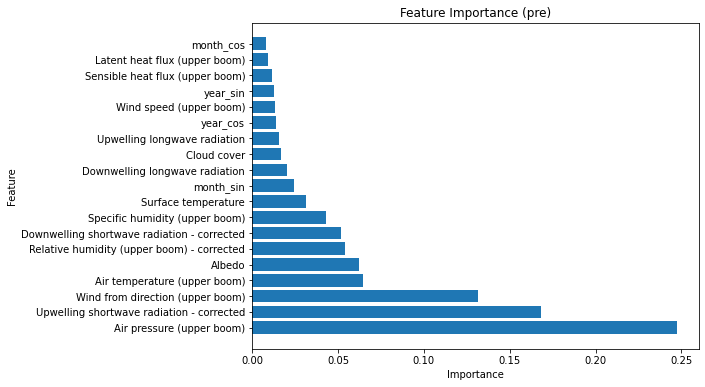

R^2 score on test set (beginning):  0.45423503307193847
MSE on test set (beginning):  0.11745288601411986
                                        Feature  Importance
0                     Air pressure (upper boom)    0.247671
1     Upwelling shortwave radiation - corrected    0.168218
2              Wind from direction (upper boom)    0.131256
3                  Air temperature (upper boom)    0.064751
4                                        Albedo    0.062215
5    Relative humidity (upper boom) - corrected    0.053865
6   Downwelling shortwave radiation - corrected    0.051953
7                Specific humidity (upper boom)    0.042894
8                           Surface temperature    0.031447
9                                     month_sin    0.024544
10               Downwelling longwave radiation    0.019988
11                                  Cloud cover    0.016553
12                 Upwelling longwave radiation    0.015547
13                                     year_cos    0.0

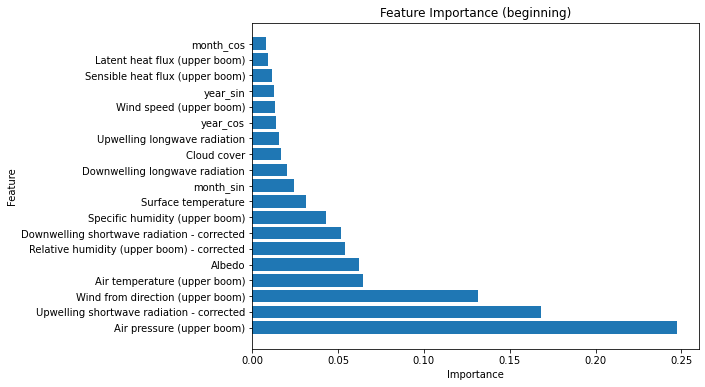

R^2 score on test set (middle):  -1.119399232134774
MSE on test set (middle):  0.0008921227173484716
                                        Feature  Importance
0                     Air pressure (upper boom)    0.247671
1     Upwelling shortwave radiation - corrected    0.168218
2              Wind from direction (upper boom)    0.131256
3                  Air temperature (upper boom)    0.064751
4                                        Albedo    0.062215
5    Relative humidity (upper boom) - corrected    0.053865
6   Downwelling shortwave radiation - corrected    0.051953
7                Specific humidity (upper boom)    0.042894
8                           Surface temperature    0.031447
9                                     month_sin    0.024544
10               Downwelling longwave radiation    0.019988
11                                  Cloud cover    0.016553
12                 Upwelling longwave radiation    0.015547
13                                     year_cos    0.013921

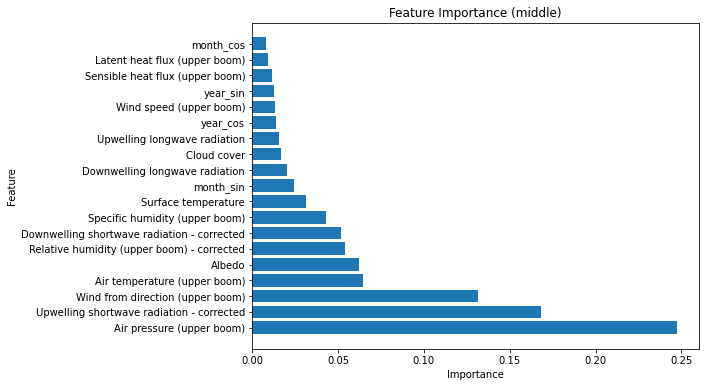

R^2 score on test set (end):  -0.05017465918048214
MSE on test set (end):  0.0003161878941654565
                                        Feature  Importance
0                     Air pressure (upper boom)    0.247671
1     Upwelling shortwave radiation - corrected    0.168218
2              Wind from direction (upper boom)    0.131256
3                  Air temperature (upper boom)    0.064751
4                                        Albedo    0.062215
5    Relative humidity (upper boom) - corrected    0.053865
6   Downwelling shortwave radiation - corrected    0.051953
7                Specific humidity (upper boom)    0.042894
8                           Surface temperature    0.031447
9                                     month_sin    0.024544
10               Downwelling longwave radiation    0.019988
11                                  Cloud cover    0.016553
12                 Upwelling longwave radiation    0.015547
13                                     year_cos    0.013921
14 

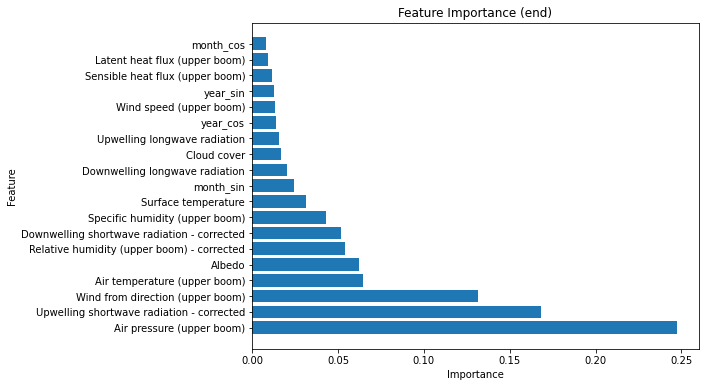

In [188]:
### This bit for delta
for category in ['pre','beginning', 'middle', 'end']:
    indices = eval(f"indices_{category}")  # Get the indices for the current category
    
    # Find common indexes
    X_Test_valid_indices = indices.intersection(X_delta_test.index)
    y_Test_valid_indices = indices.intersection(y_delta_test.index)
    
    # filter out by indeces
    X_test_category = X_delta_test.loc[X_Test_valid_indices]  
    y_test_category = y_delta_test.loc[y_Test_valid_indices]  
    
    # Apply XGB on all periods  
    #model_delta.fit(X_train_category, y_train_category)
    y_pred_category = model_delta.predict(X_test_category)
    
    r2 = r2_score(y_test_category, y_pred_category)
    mse = mean_squared_error(y_test_category, y_pred_category)
    print(f"R^2 score on test set ({category}): ", r2)
    print(f"MSE on test set ({category}): ", mse)
    feature_importance =  model_delta.feature_importances_

    # Get the feature importance scores and plot them
    feature_importance = pd.DataFrame({'Feature': X_delta_train.columns, 'Importance': model_delta.feature_importances_})
    feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)
    print(feature_importance)

    # Plot the feature importance scores
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Feature Importance ({category})')
    plt.show()

In [191]:
for category in ['beginning', 'middle', 'end']:
    indices = eval(f"indices_{category}")  # Get the indices for the current category
    valid_indices = set(indices).intersection(X_test.index).intersection(y_test.index)
    # Filter X_test and y_test by the current category's valid indices
    X_test_category = X_test.loc[valid_indices]
    y_test_category = y_test.loc[valid_indices]
    print(f"Results for {category} category:")

Results for beginning category:
Results for middle category:
Results for end category:


/var/folders/_r/2f7t_cz14232jqp3576_p04m0000gn/T/ipykernel_46484/3691237972.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_test_category = X_test.loc[valid_indices]
/var/folders/_r/2f7t_cz14232jqp3576_p04m0000gn/T/ipykernel_46484/3691237972.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  y_test_category = y_test.loc[valid_indices]
/var/folders/_r/2f7t_cz14232jqp3576_p04m0000gn/T/ipykernel_46484/3691237972.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_test_category = X_test.loc[valid_indices]
/var/folders/_r/2f7t_cz14232jqp3576_p04m0000gn/T/ipykernel_46484/3691237972.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  y_test_category = y_test.loc[valid_indices]
/var/folders/_r/2f7t_cz14232jqp3576_

## Test Suite

In [190]:
### This bit for delta
for category in ['pre','beginning', 'middle', 'end']:
    indices = eval(f"indices_{category}")  # Get the indices for the current category
    
    # Find common indexes
    X_Test_valid_indices = indices.intersection(X_delta_test.index)
    y_Test_valid_indices = indices.intersection(y_delta_test.index)
    
    # filter out by indeces
    X_test_category = X_delta_test.loc[X_Test_valid_indices]  
    y_test_category = y_delta_test.loc[y_Test_valid_indices]  
    
    # Fit XGB on the current subset of data
    model_delta = model_delta
    model_delta.fit(X_delta_train.loc[indices], y_delta_train.loc[indices])
    
    # Apply XGB on the current subset of data  
    y_pred_category = model_delta.predict(X_test_category)
    
    r2 = r2_score(y_test_category, y_pred_category)
    mse = mean_squared_error(y_test_category, y_pred_category)
    print(f"R^2 score on test set ({category}): ", r2)
    print(f"MSE on test set ({category}): ", mse)
    
    # Get the feature importance scores and plot them for the current subset of data
    feature_importance = pd.DataFrame({'Feature': X_delta_train.columns, 'Importance': model_delta.feature_importances_})
    feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)
    print(feature_importance)

    # Plot the feature importance scores for the current subset of data
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Feature Importance ({category})')
    plt.show()


NameError: name 'XGBRegressor' is not defined

--------